 ### Notebook to genereate cross sections from TC output binned according to a 2D variable.

 Assumes output is in a single netcdf file on pressure levels.

 James Ruppert
 jruppert@ou.edu
 4/23/22

 #### Main settings

In [1]:
import numpy as np
import matplotlib
from matplotlib import ticker, colors
import matplotlib.pyplot as plt
import sys
from thermo_functions import *
# from mask_tc_track import mask_tc_track
from precip_class import precip_class
from memory_usage import memory_usage
from read_functions import *
import pickle

In [2]:
# Index variable (2D; independent var)
# ivar_select = 'pw'
ivar_select = 'sf'
# ivar_select = 'rain'
# options (requiring 2D info): pw, rain, lwacre
# options (requiring 3D info): vmf

# Fill variable (3D; dependent var)
fillvar_select = 'lwcrf'
# options: avor, lwcrf, tprm, dbz, rh

# Contour variable (3D; dependent var)
contvar_select = 'w'

# Vertical high resolution?
do_hires=True
# do_hires=False

do_tests=True
# do_tests=False

# Number of sample time steps
# nt=12
nt=6
# nt=2

 #### Additional settings and directories

In [3]:
storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
datdir2 = 'post/d02/'

# Tests to read and compare
# tests = ['crfon','ncrf']
if storm == 'haiyan':
    if do_tests:
        tests = ['ctl','ncrf36h','STRATANVIL_OFF','STRATANVIL_ON','STRAT_OFF']
    else:
        tests = ['ctl']
    # tests = ['ctl','ncrf36h']
elif storm == 'maria':
    if do_tests:
        # tests = ['ctl','ncrf36h']
        tests = ['ctl','ncrf48h']
    else:
        tests = ['ctl']
ntest=len(tests)

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 2
enstag = str(nmem)

In [4]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
if do_hires:
    nz=39
    pres = np.arange(1000,25,-25)
    dp=(pres[0]-pres[1])*1e2

# Get WRF file list
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
wrffiles, lat, lon = get_wrf_filelist(datdir)

 #### Index aka Bin variable

In [5]:
# Variable settings

# PW
if ivar_select == 'pw':
    fmin=35;fmax=80 # mm
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel='Column water vapor [mm]'
    log_x='linear'
# Column saturation fraction
elif ivar_select == 'sf':
    # fmin=30;fmax=100 # %
    fmin=.3;fmax=1 # %
    step=0.01
    bins=np.arange(fmin,fmax+step,step)
    # xlabel='Column saturation fraction [%]'
    xlabel='Column saturation fraction'
    log_x='linear'
# Rainfall rate
elif ivar_select == 'rain':
    # bins=10.**(np.arange(1,8,0.3)-4)
    bins=10.**(np.arange(0,8,0.3)-4)
    xlabel='Rainfall rate [mm/hr]'
    log_x='log'
# LW-ACRE
elif ivar_select == 'lwacre':
    fmin=-50; fmax=200 # W/m2
    step=5
    bins=np.arange(fmin,fmax+step,step)
    xlabel='LW-ACRE [W/m**2]'
    log_x='linear'
# Vertical mass flux
elif ivar_select == 'vmf':
    bins=10.**(np.arange(1,8,0.3)-3)
    # bins=np.flip(-1.*bins)
    xlabel='Vertical mass flux [kg/m/s]'
    log_x='log'
# Theta-e (equivalent potential temperature)
elif ivar_select == 'th_e':
    fmin=315; fmax=365 # K
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel=r'$\theta_e$ [K]'
    log_x='linear'

nbins = np.size(bins)

# Create axis of bin center-points for plotting
bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2


 ### Read from pickle file

In [6]:
var_binned=np.ma.zeros((ntest,nbins-1,nz))
cvar_binned=np.ma.zeros((ntest,nbins-1,nz))
strat_binned=np.ma.zeros((ntest,nbins-1,6)) # Bin count: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
lwacre_binned=np.ma.zeros((ntest,nbins-1))
rain_binned=np.ma.zeros((ntest,nbins-1))
lwacre_strat=np.ma.zeros((ntest,nbins-1,6)) # LWACRE in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
rain_strat=np.ma.zeros((ntest,nbins-1,6)) # rain in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil

for itest in range(ntest):
    pickle_file = main_pickle+'/binned_2d_'+tests[itest]+'_'+ivar_select+'_'+str(nmem)+'memb_'+str(nt)+'hrs.pkl'
    with open(pickle_file, 'rb') as file:
        bins, ivar_binned, icvar_binned, ilwacre_binned, irain_binned, \
            istrat_binned, ilwacre_strat, irain_strat = pickle.load(file)
    var_binned[itest,...]    = ivar_binned
    cvar_binned[itest,...]   = icvar_binned
    strat_binned[itest,...]  = istrat_binned
    lwacre_binned[itest,...] = ilwacre_binned
    rain_binned[itest,...]   = irain_binned
    lwacre_strat[itest,...]  = ilwacre_strat
    rain_strat[itest,...]    = irain_strat


---
## Plotting routines

In [7]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)


### Figure settings

In [8]:
# Three-dimensional dependent variables ("var")

# Radar Reflectivity
if fillvar_select == 'dbz':
    title = 'Ref'
    units_var1 = 'dBZ'
    cmin = -20; cmax=20
    cmap='RdBu_r'
# Radiation
elif fillvar_select == 'lwcrf':
    title = 'LW-CRF'
    figtag = fillvar_select
    cmap='RdBu_r'
    units_var1 = 'K/d'
    cmax=4; cmin=-1.*cmax
# Horizontal temperature anomaly
elif fillvar_select == 'tprm':
    title = r"$\theta_v'$"
    figtag = 'thprm'
    units_var1 = 'K'
    # cmax=1; cmin=-1.*cmax
    cmap='RdBu_r'
    cmax=2; cmin=-1.*cmax
    cmax_diff=.4; cmin_diff=-1.*cmax_diff
# Relative humidity
elif fillvar_select == 'rh':
    title = "RH"
    figtag = fillvar_select
    units_var1 = '%'
    cmap='RdBu_r'
    cmax=100; cmin=20
    cmax_diff=2; cmin_diff=-1*cmax_diff
# Absolute vorticity
elif fillvar_select == 'avor':
    title = "AVor"
    figtag = fillvar_select
    cmap='GnBu'
    units_var1 = '10$^{-6}$ /s'
    cmax=100; cmin=20
    cmax_diff=100; cmin_diff=-1*cmax_diff


### Main cross section

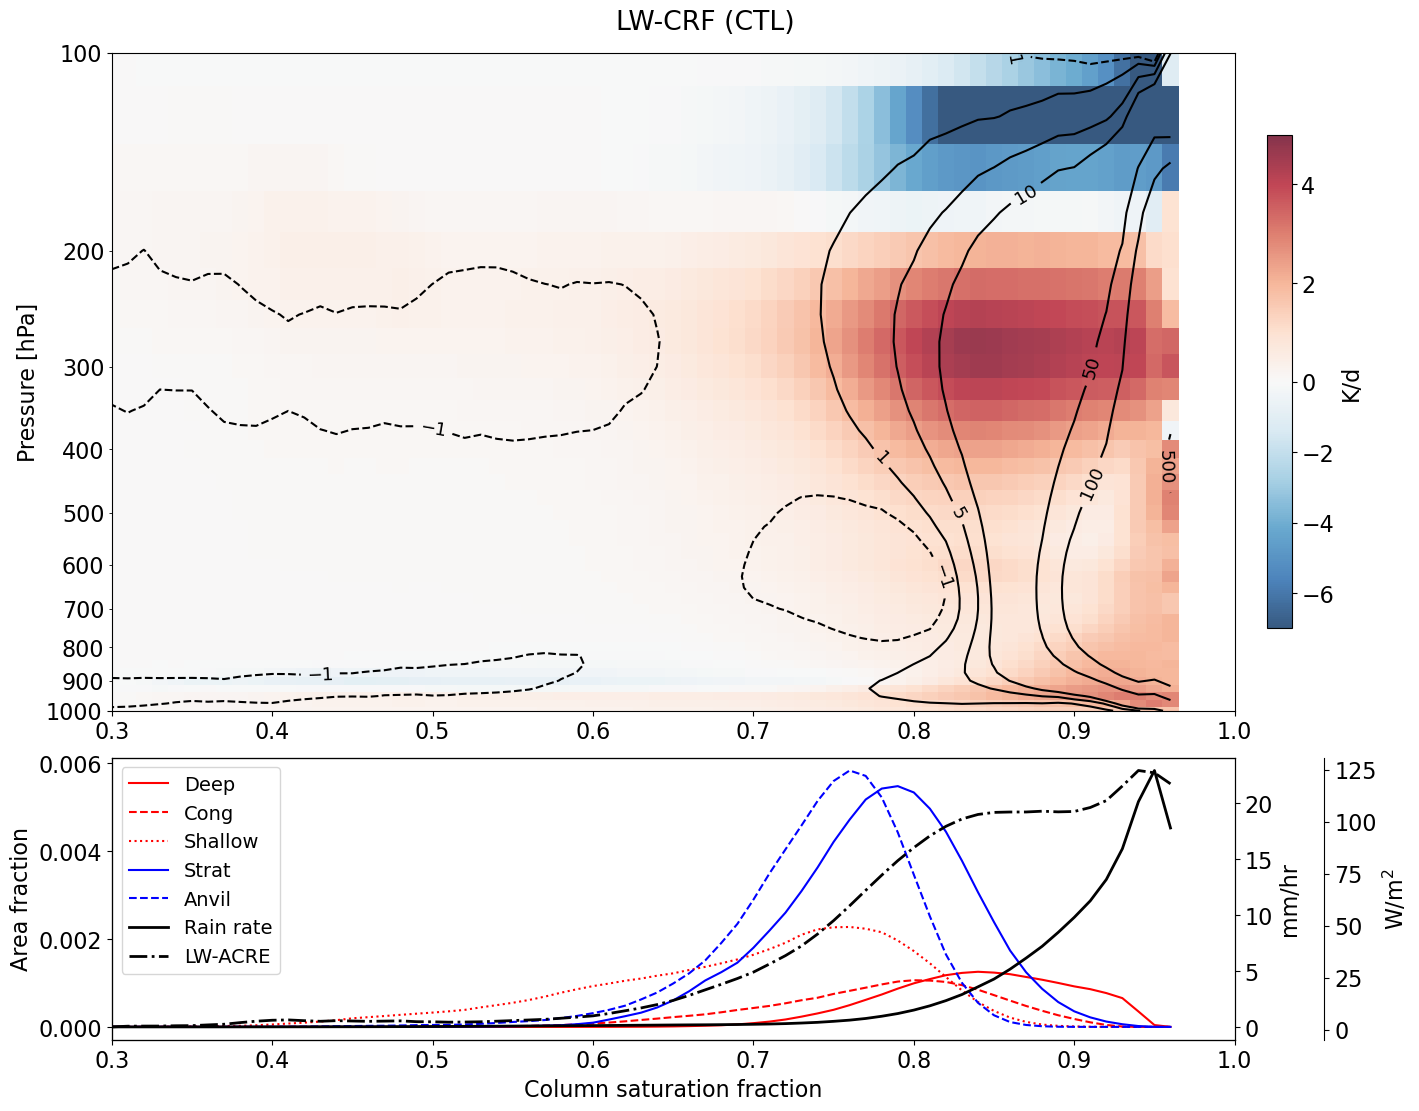

In [9]:
# Loop over sensitivity tests
# for ktest in range(ntest):
for ktest in range(1):

        test_str=tests[ktest].upper()
        # if istrat > -1:
        #     fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
        # else:
        fig_title = title+' ('+test_str.upper()+')'# ('+hr_tag+' h)'
        
        # create figure
        # fig = plt.figure(figsize=(14,8))
        # ax = fig.add_subplot(111)
        fig, axs = plt.subplots(2, 1, figsize=(14,11), height_ratios=[.7,.3], layout='constrained',
                                squeeze=True)
        fig.suptitle(fig_title)

        ########################################

        # MAIN PANEL

        axs[0].set_ylabel('Pressure [hPa]')

        pltvar=var_binned[ktest,:,:]
        cpltvar=cvar_binned[ktest,:,:]

        # fill contour
        nlevs=31
        inc=(cmax-cmin)/nlevs
        clevs = np.arange(cmin, cmax+inc, inc)
        # im = axs[0].contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap=cmap, alpha=0.8, \
        #                 extend='both', zorder=2)
        norm = colors.TwoSlopeNorm(vmin=-7, vcenter=0, vmax=5)
        im = axs[0].pcolormesh(bins[0:nbins-1], pres, np.transpose(pltvar), cmap=cmap, alpha=0.8, \
                        norm=norm,zorder=2)

        fig.colorbar(im, ax=axs[0], shrink=0.75, ticks=ticker.AutoLocator(), label=units_var1,
                        pad=-0.12)

        axs[0].set_ylim(100,np.max(pres))
        axs[0].invert_yaxis()
        axs[0].set_yscale('log')
        axs[0].set_xscale(log_x)
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[0].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

        # axs[0].set_xlabel(xlabel)
        axs[0].set_xlim(np.min(bins), np.max(bins))

        # Line contour
        # clevs = np.arange(lcmin, lcmax, lcint)
        # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
        clevs = [1,5,10,50,100,500,1000,2000,3000]
        clevs = np.concatenate((-1*np.flip(clevs),clevs))
        # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
        im = axs[0].contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
        axs[0].clabel(im, im.levels, inline=True, fontsize=13)

        ########################################

        # STRAT FRACTION PANEL
        subp_title = 'Cloud Classification'# ('+hr_tag+' h)'
        # axs[1].set_title(subp_title)
        axs[1].set_xlabel(xlabel)
        axs[1].set_xscale(log_x)

        # As fraction of all-points-total
        axs[1].set_ylabel('Area fraction')

        total=np.nansum(strat_binned[ktest,:,:])
        # axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,0]/total \
        #         , ".k", label="Non-raining")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,1]/total \
                , "-r", label="Deep")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,2]/total \
                , "--r", label="Cong")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,3]/total \
                , ":r", label="Shallow")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,4]/total \
                , "-b", label="Strat")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,5]/total \
                , "--b", label="Anvil")

        axs[1].set_xlim(np.min(bins), np.max(bins))
        # axs[1].set_ylim(0, 0.020)

        # Dummy placeholders just to include in legend
        axs[1].plot(bins[0:nbins-1], rain_binned[ktest,:]*np.nan, "-k", label="Rain rate", linewidth=2)
        axs[1].plot(bins[0:nbins-1], lwacre_binned[ktest,:]*np.nan, "-.k", label="LW-ACRE", linewidth=2)

        axs[1].legend(loc="upper left")

        # Add rain rate

        twin1 = axs[1].twinx()
        rain_hrly = rain_binned/24 # mm/d --> mm/hr
        twin1.plot(bins[0:nbins-1], rain_hrly[ktest,:], "-k", label="Rain", linewidth=2)
        twin1.set_ylabel('mm/hr')

        axs[1].legend(loc="upper left", prop={'size': 14})

        # Add LW-ACRE
        twin2 = axs[1].twinx()
        twin2.spines.right.set_position(("axes", 1.08))
        twin2.plot(bins[0:nbins-1], lwacre_binned[ktest,:], "-.k", label="LW-ACRE", linewidth=2)
        twin2.set_ylabel('W/m$^2$')

        # figtag2 = figtag+'_'+ivar_select+fig_extra
        # plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

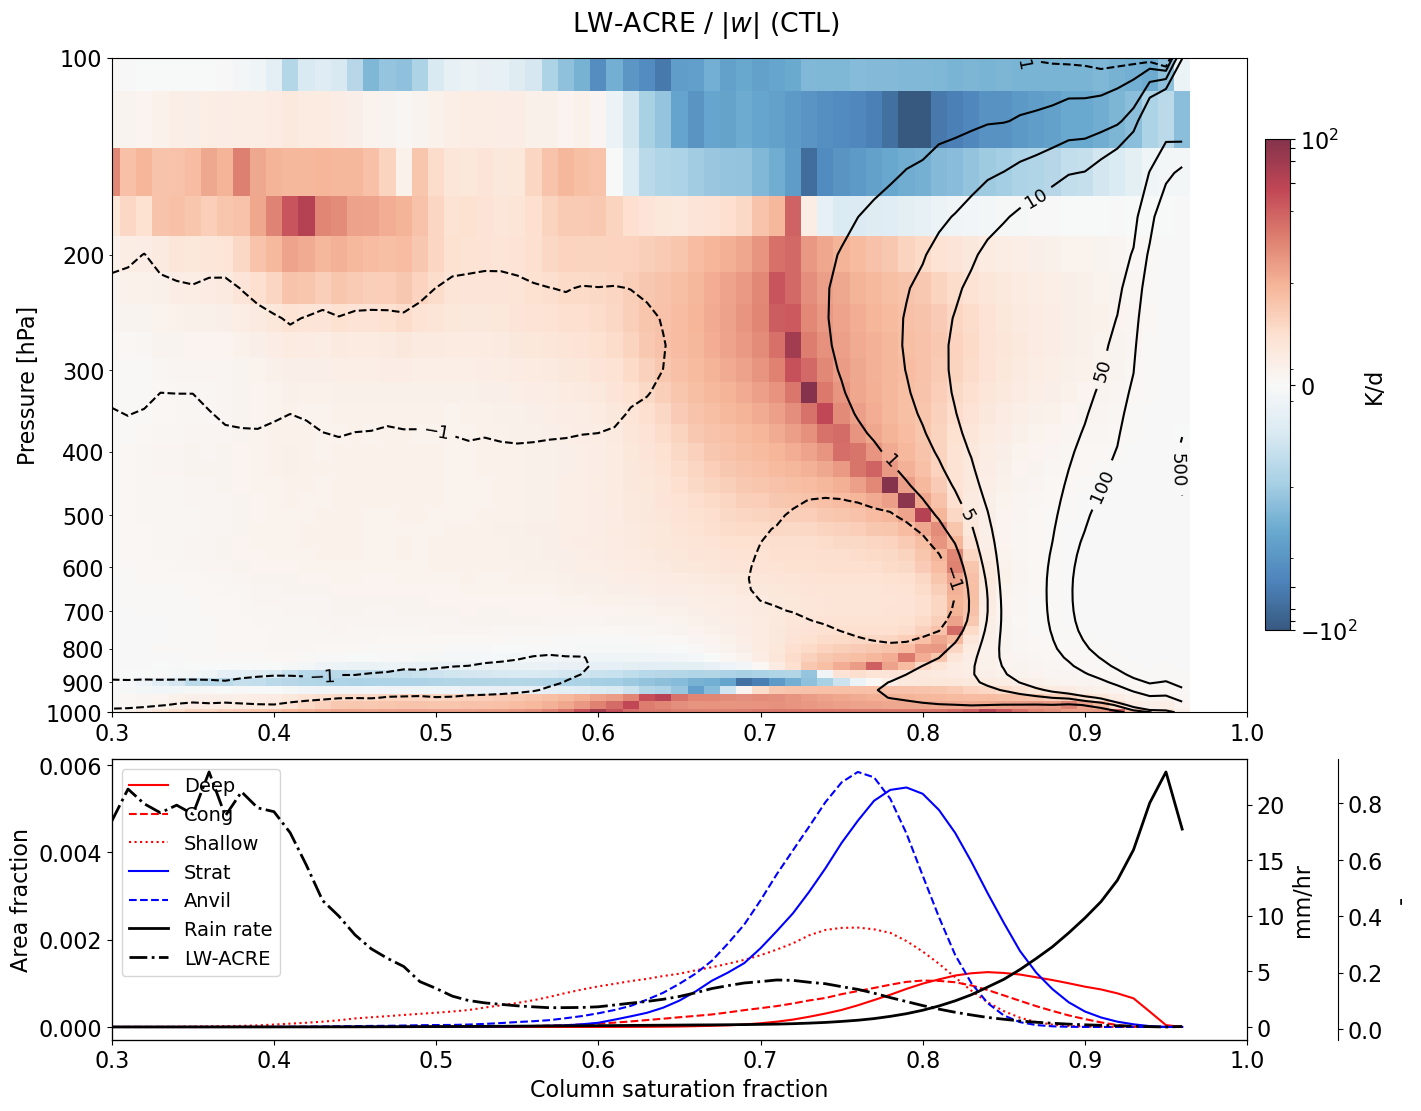

In [10]:
# Loop over sensitivity tests
# for ktest in range(ntest):
for ktest in range(1):

        test_str=tests[ktest].upper()
        # if istrat > -1:
        #     fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
        # else:
        # fig_title = title+' ('+test_str.upper()+')'# ('+hr_tag+' h)'
        fig_title = 'LW-ACRE / $|w|$ ('+test_str.upper()+')'# ('+hr_tag+' h)'
        
        # create figure
        # fig = plt.figure(figsize=(14,8))
        # ax = fig.add_subplot(111)
        fig, axs = plt.subplots(2, 1, figsize=(14,11), height_ratios=[.7,.3], layout='constrained',
                                squeeze=True)
        fig.suptitle(fig_title)

        ########################################

        # MAIN PANEL

        axs[0].set_ylabel('Pressure [hPa]')

        pltvar=var_binned[ktest,:,:]
        cpltvar=cvar_binned[ktest,:,:]

        # fill contour
        nlevs=31
        inc=(cmax-cmin)/nlevs
        clevs = np.arange(cmin, cmax+inc, inc)
        # im = axs[0].contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap=cmap, alpha=0.8, \
        #                 extend='both', zorder=2)

        factor = np.abs(1/cpltvar)
        norm = colors.SymLogNorm(linthresh=0.5, linscale=1, vmin=-1e2, vmax=1e2)
        im = axs[0].pcolormesh(bins[0:nbins-1], pres, np.transpose(pltvar*factor), cmap=cmap, alpha=0.8, \
                        norm=norm, zorder=2)

        fig.colorbar(im, ax=axs[0], shrink=0.75, ticks=ticker.AutoLocator(), label=units_var1,
                        pad=-0.12)

        axs[0].set_ylim(100,np.max(pres))
        axs[0].invert_yaxis()
        axs[0].set_yscale('log')
        axs[0].set_xscale(log_x)
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[0].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

        # axs[0].set_xlabel(xlabel)
        axs[0].set_xlim(np.min(bins), np.max(bins))

        # Line contour
        # clevs = np.arange(lcmin, lcmax, lcint)
        # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
        clevs = [1,5,10,50,100,500,1000,2000,3000]
        clevs = np.concatenate((-1*np.flip(clevs),clevs))
        # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
        im = axs[0].contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
        axs[0].clabel(im, im.levels, inline=True, fontsize=13)

        ########################################

        # Calculate LW-ACRE/VMF
        # vmf = np.sum(cpltvar/1e2, axis=1)*dp*9.81 # w --> m/s; p: Pa; g: m/s^2

        ########################################

        # STRAT FRACTION PANEL
        subp_title = 'Cloud Classification'# ('+hr_tag+' h)'
        # axs[1].set_title(subp_title)
        axs[1].set_xlabel(xlabel)
        axs[1].set_xscale(log_x)

        # As fraction of all-points-total
        axs[1].set_ylabel('Area fraction')

        total=np.nansum(strat_binned[ktest,:,:])
        # axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,0]/total \
        #         , ".k", label="Non-raining")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,1]/total \
                , "-r", label="Deep")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,2]/total \
                , "--r", label="Cong")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,3]/total \
                , ":r", label="Shallow")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,4]/total \
                , "-b", label="Strat")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,5]/total \
                , "--b", label="Anvil")

        axs[1].set_xlim(np.min(bins), np.max(bins))
        # axs[1].set_ylim(0, 0.020)

        # Dummy placeholders just to include in legend
        axs[1].plot(bins[0:nbins-1], rain_binned[ktest,:]*np.nan, "-k", label="Rain rate", linewidth=2)
        axs[1].plot(bins[0:nbins-1], lwacre_binned[ktest,:]*np.nan, "-.k", label="LW-ACRE", linewidth=2)

        axs[1].legend(loc="upper left")

        # Add rain rate

        twin1 = axs[1].twinx()
        rain_hrly = rain_binned/24 # mm/d --> mm/hr
        twin1.plot(bins[0:nbins-1], rain_hrly[ktest,:], "-k", label="Rain", linewidth=2)
        twin1.set_ylabel('mm/hr')

        axs[1].legend(loc="upper left", prop={'size': 14})

        # Add LW-ACRE
        twin2 = axs[1].twinx()
        twin2.spines.right.set_position(("axes", 1.08))
        # twin2.plot(bins[0:nbins-1], lwacre_binned[ktest,:], "-.k", label="LW-ACRE", linewidth=2)
        # twin2.set_ylabel('W/m$^2$')
        lv0=2.5e6
        rain_wm2 = rain_binned[ktest,:]*lv0/(24*3600)
        feedback = lwacre_binned[ktest,:] / rain_wm2
        twin2.plot(bins[0:nbins-1], feedback, "-.k", label="LW-ACRE", linewidth=2)
        twin2.set_ylabel('-')

        # figtag2 = figtag+'_'+ivar_select+fig_extra
        # plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

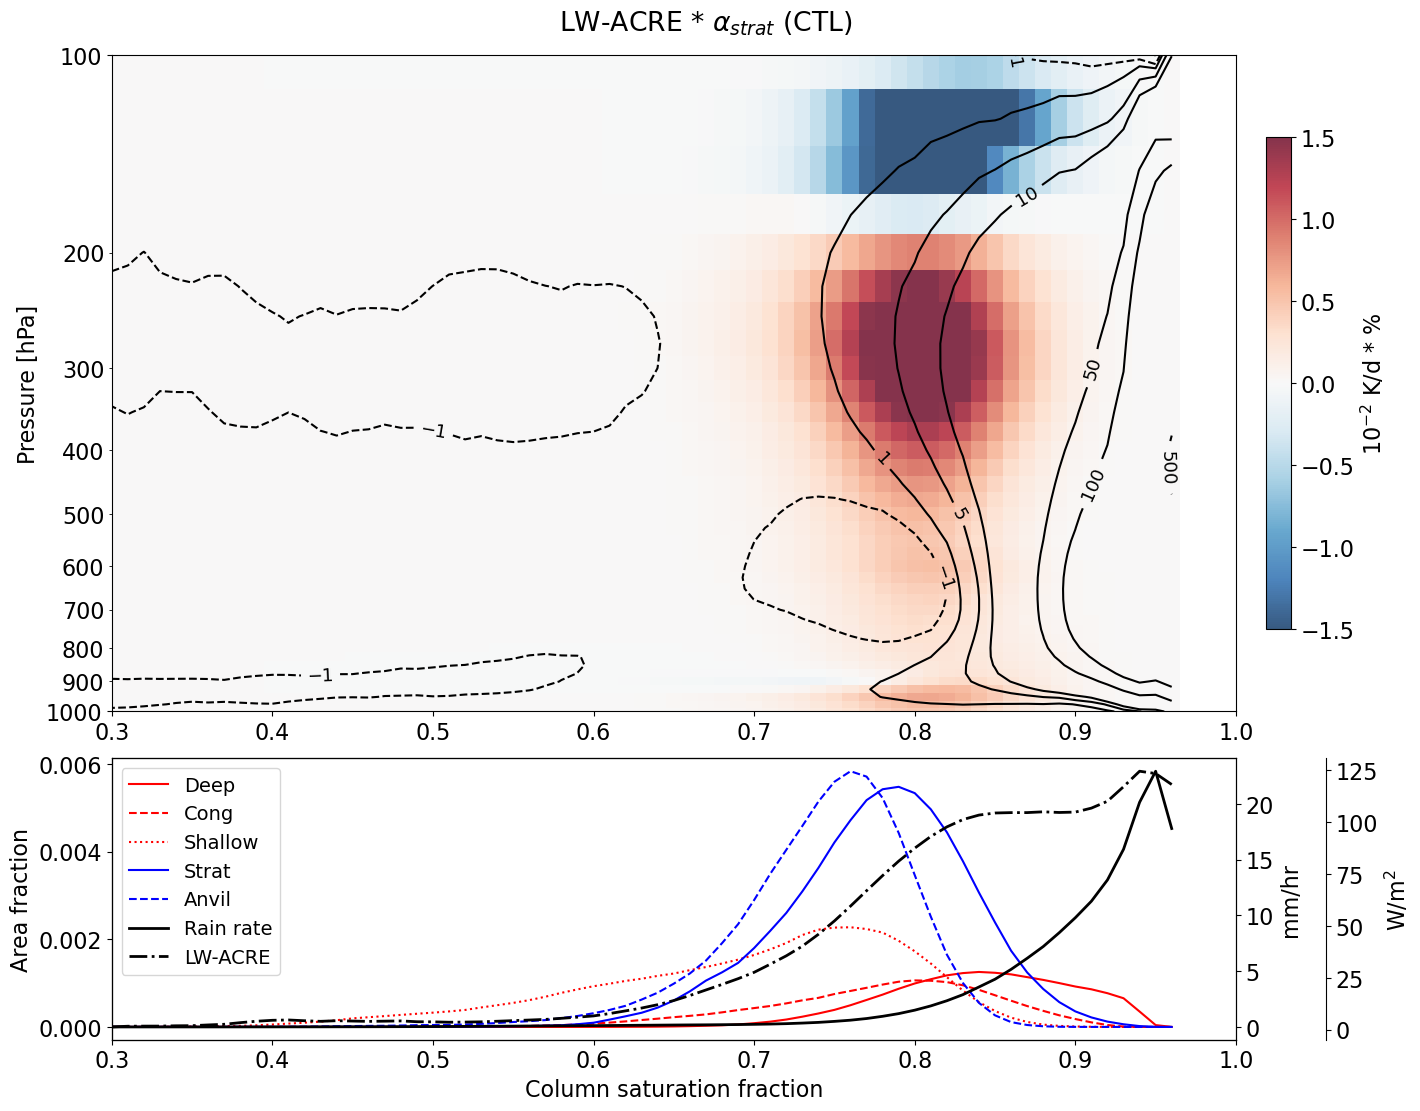

In [11]:
# Loop over sensitivity tests
# for ktest in range(ntest):
for ktest in range(1):

        test_str=tests[ktest].upper()
        # if istrat > -1:
        #     fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
        # else:
        # fig_title = title+' ('+test_str.upper()+')'# ('+hr_tag+' h)'
        fig_title = r'LW-ACRE * $\alpha_{strat}$ ('+test_str.upper()+')'# ('+hr_tag+' h)'
        
        # create figure
        # fig = plt.figure(figsize=(14,8))
        # ax = fig.add_subplot(111)
        fig, axs = plt.subplots(2, 1, figsize=(14,11), height_ratios=[.7,.3], layout='constrained',
                                squeeze=True)
        fig.suptitle(fig_title)

        ########################################

        # MAIN PANEL

        axs[0].set_ylabel('Pressure [hPa]')

        pltvar=var_binned[ktest,:,:]
        cpltvar=cvar_binned[ktest,:,:]

        # fill contour
        nlevs=31
        inc=(cmax-cmin)/nlevs
        clevs = np.arange(cmin, cmax+inc, inc)
        # im = axs[0].contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap=cmap, alpha=0.8, \
        #                 extend='both', zorder=2)
        total=np.nansum(strat_binned[ktest,:,:])
        factor = (strat_binned[ktest,:,4]/total)[...,np.newaxis]*1e2
        # norm = colors.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)
        norm = colors.Normalize(vmin=-1.5, vmax=1.5)
        im = axs[0].pcolormesh(bins[0:nbins-1], pres, np.transpose(pltvar*factor), cmap=cmap, alpha=0.8, \
                        norm=norm, zorder=2)

        fig.colorbar(im, ax=axs[0], shrink=0.75, ticks=ticker.AutoLocator(), label="10$^{-2}$ K/d * %",
                        pad=-0.12)

        axs[0].set_ylim(100,np.max(pres))
        axs[0].invert_yaxis()
        axs[0].set_yscale('log')
        axs[0].set_xscale(log_x)
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[0].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

        # axs[0].set_xlabel(xlabel)
        axs[0].set_xlim(np.min(bins), np.max(bins))

        # Line contour
        # clevs = np.arange(lcmin, lcmax, lcint)
        # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
        clevs = [1,5,10,50,100,500,1000,2000,3000]
        clevs = np.concatenate((-1*np.flip(clevs),clevs))
        # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
        im = axs[0].contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
        axs[0].clabel(im, im.levels, inline=True, fontsize=13)

        ########################################

        # STRAT FRACTION PANEL
        subp_title = 'Cloud Classification'# ('+hr_tag+' h)'
        # axs[1].set_title(subp_title)
        axs[1].set_xlabel(xlabel)
        axs[1].set_xscale(log_x)

        # As fraction of all-points-total
        axs[1].set_ylabel('Area fraction')

        total=np.nansum(strat_binned[ktest,:,:])
        # axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,0]/total \
        #         , ".k", label="Non-raining")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,1]/total \
                , "-r", label="Deep")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,2]/total \
                , "--r", label="Cong")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,3]/total \
                , ":r", label="Shallow")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,4]/total \
                , "-b", label="Strat")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,5]/total \
                , "--b", label="Anvil")

        axs[1].set_xlim(np.min(bins), np.max(bins))
        # axs[1].set_ylim(0, 0.020)

        # Dummy placeholders just to include in legend
        axs[1].plot(bins[0:nbins-1], rain_binned[ktest,:]*np.nan, "-k", label="Rain rate", linewidth=2)
        axs[1].plot(bins[0:nbins-1], lwacre_binned[ktest,:]*np.nan, "-.k", label="LW-ACRE", linewidth=2)

        axs[1].legend(loc="upper left")

        # Add rain rate

        twin1 = axs[1].twinx()
        rain_hrly = rain_binned/24 # mm/d --> mm/hr
        twin1.plot(bins[0:nbins-1], rain_hrly[ktest,:], "-k", label="Rain", linewidth=2)
        twin1.set_ylabel('mm/hr')

        axs[1].legend(loc="upper left", prop={'size': 14})

        # Add LW-ACRE
        twin2 = axs[1].twinx()
        twin2.spines.right.set_position(("axes", 1.08))
        twin2.plot(bins[0:nbins-1], lwacre_binned[ktest,:], "-.k", label="LW-ACRE", linewidth=2)
        twin2.set_ylabel('W/m$^2$')

        # figtag2 = figtag+'_'+ivar_select+fig_extra
        # plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

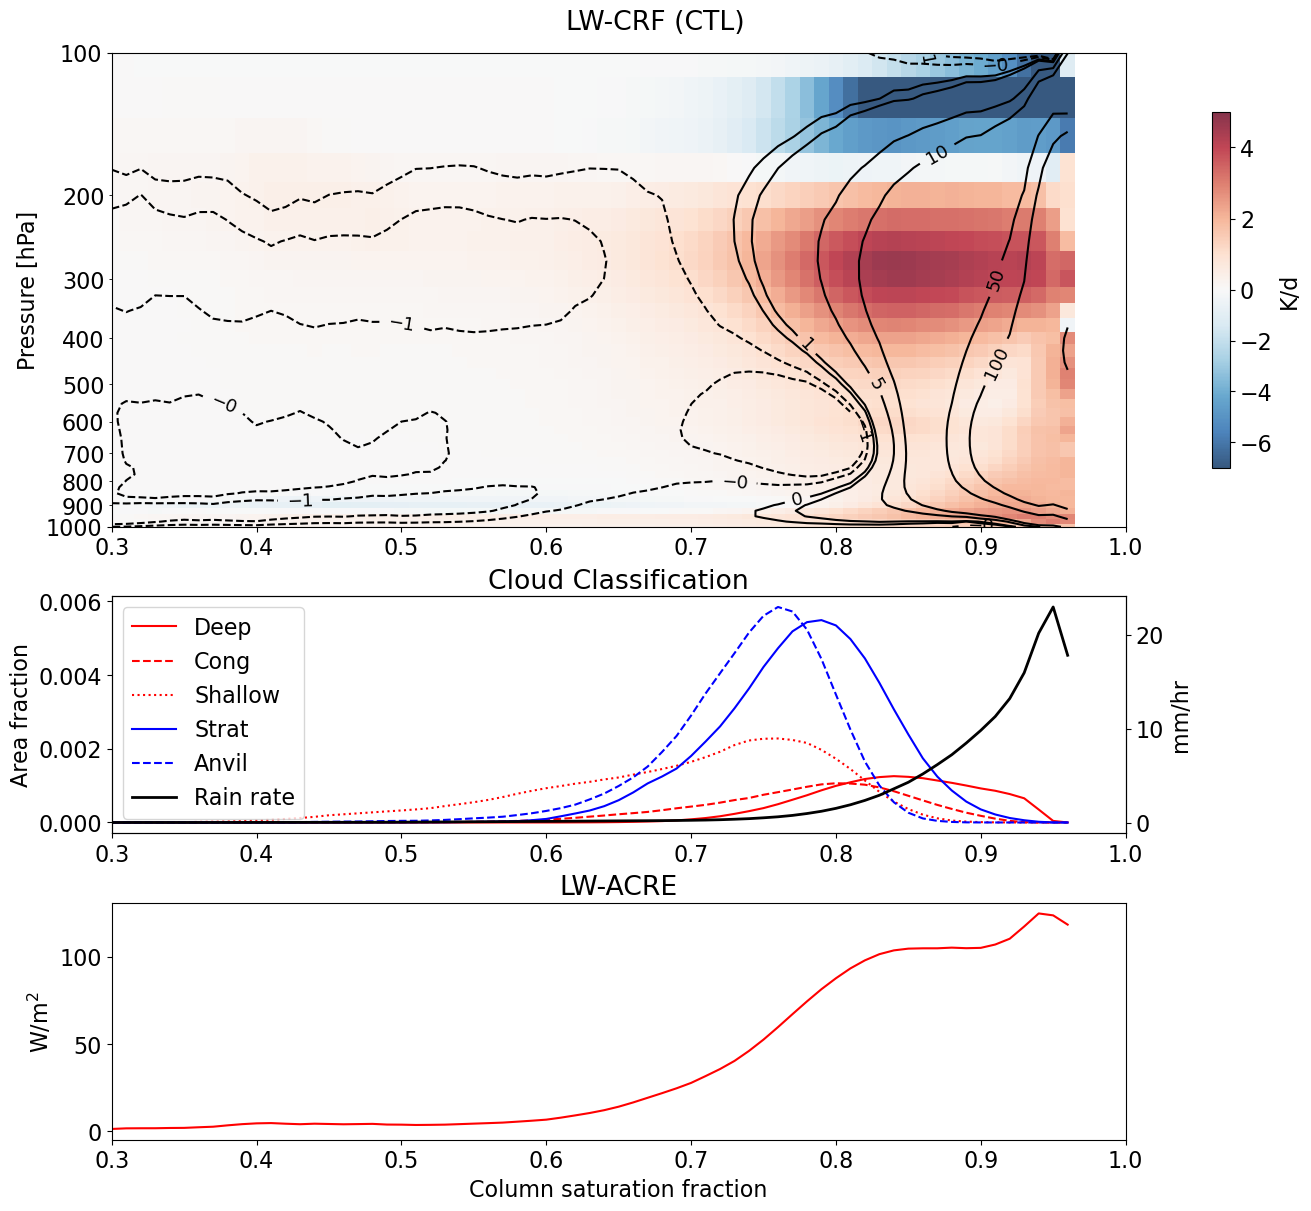

In [12]:
# Loop over sensitivity tests
# for ktest in range(ntest):
for ktest in range(1):

        test_str=tests[ktest].upper()
        # if istrat > -1:
        #     fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
        # else:
        fig_title = title+' ('+test_str.upper()+')'# ('+hr_tag+' h)'
        
        # create figure
        # fig = plt.figure(figsize=(14,8))
        # ax = fig.add_subplot(111)
        fig, axs = plt.subplots(3, 1, figsize=(13,12), height_ratios=[.5,.25,.25], layout='constrained',
                                squeeze=True)
        fig.suptitle(fig_title)

        ########################################

        # MAIN PANEL

        axs[0].set_ylabel('Pressure [hPa]')

        pltvar=var_binned[ktest,:,:]
        cpltvar=cvar_binned[ktest,:,:]

        # fill contour
        nlevs=31
        inc=(cmax-cmin)/nlevs
        clevs = np.arange(cmin, cmax+inc, inc)
        # im = axs[0].contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap=cmap, alpha=0.8, \
        #                 extend='both', zorder=2)
        norm = colors.TwoSlopeNorm(vmin=-7, vcenter=0, vmax=5)
        im = axs[0].pcolormesh(bins[0:nbins-1], pres, np.transpose(pltvar), cmap=cmap, alpha=0.8, \
                        norm=norm, zorder=2)

        fig.colorbar(im, ax=axs[0], shrink=0.75, ticks=ticker.AutoLocator(), label=units_var1,
                        pad=0.02)

        axs[0].set_ylim(100,np.max(pres))
        axs[0].invert_yaxis()
        axs[0].set_yscale('log')
        axs[0].set_xscale(log_x)
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[0].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

        # axs[0].set_xlabel(xlabel)
        axs[0].set_xlim(np.min(bins), np.max(bins))

        # Line contour
        clevs = [0.5,1,5,10,50,100,500,1000,2000,3000]
        clevs = np.concatenate((-1*np.flip(clevs),clevs))
        # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
        im = axs[0].contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
        axs[0].clabel(im, im.levels, inline=True, fontsize=13)


        ########################################

        # CLOUD FRACTION PANEL
        subp_title = 'Cloud Classification'# ('+hr_tag+' h)'
        axs[1].set_title(subp_title)
        # axs[1].set_xlabel(xlabel)
        axs[1].set_xscale(log_x)

        # As fraction of all-points-total
        axs[1].set_ylabel('Area fraction')

        total=np.nansum(strat_binned[ktest,:,:])
        # axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,0]/total \
        #         , ".k", label="Non-raining")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,1]/total \
                , "-r", label="Deep")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,2]/total \
                , "--r", label="Cong")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,3]/total \
                , ":r", label="Shallow")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,4]/total \
                , "-b", label="Strat")
        axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,5]/total \
                , "--b", label="Anvil")

        axs[1].set_xlim(np.min(bins), np.max(bins))
        # axs[1].set_ylim(0, 0.020)

        # Dummy rain plot just to include in legend
        axs[1].plot(bins[0:nbins-1], rain_binned[ktest,:]*np.nan, "-k", label="Rain rate", linewidth=2)

        axs[1].legend(loc="upper left")

        axs2 = axs[1].twinx()
        rain_hrly = rain_binned/24 # mm/d --> mm/hr
        axs2.plot(bins[0:nbins-1], rain_hrly[ktest,:], "-k", label="Rain", linewidth=2)
        axs2.set_ylabel('mm/hr')


        ########################################

        # PCLASS-CONDITIONAL RAIN RATES
        subp_title = 'LW-ACRE'# ('+hr_tag+' h)'
        axs[2].set_title(subp_title)
        axs[2].set_xlabel(xlabel)
        axs[2].set_xscale(log_x)

        # As fraction of all-points-total
        axs[2].set_ylabel('W/m$^2$')

        axs[2].plot(bins[0:nbins-1], lwacre_binned[ktest,:] \
                , "-r", label="Deep")
        # axs[2].plot(bins[0:nbins-1], lwacre_strat[ktest,:,1]*strat_binned[ktest,:,1]/total \
        #         , "-r", label="Deep")
        # axs[2].plot(bins[0:nbins-1], lwacre_strat[ktest,:,2]*strat_binned[ktest,:,2]/total \
        #         , "--r", label="Cong")
        # axs[2].plot(bins[0:nbins-1], lwacre_strat[ktest,:,3]*strat_binned[ktest,:,3]/total \
        #         , ":r", label="Shallow")
        # axs[2].plot(bins[0:nbins-1], lwacre_strat[ktest,:,4]*strat_binned[ktest,:,4]/total \
        #         , "-b", label="Strat")
        # axs[2].plot(bins[0:nbins-1], lwacre_strat[ktest,:,5]*strat_binned[ktest,:,5]/total \
        #         , "--b", label="Anvil")

        axs[2].set_xlim(np.min(bins), np.max(bins))

        # figtag2 = figtag+'_'+ivar_select+fig_extra
        # plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()


### Difference between sensitivity tests

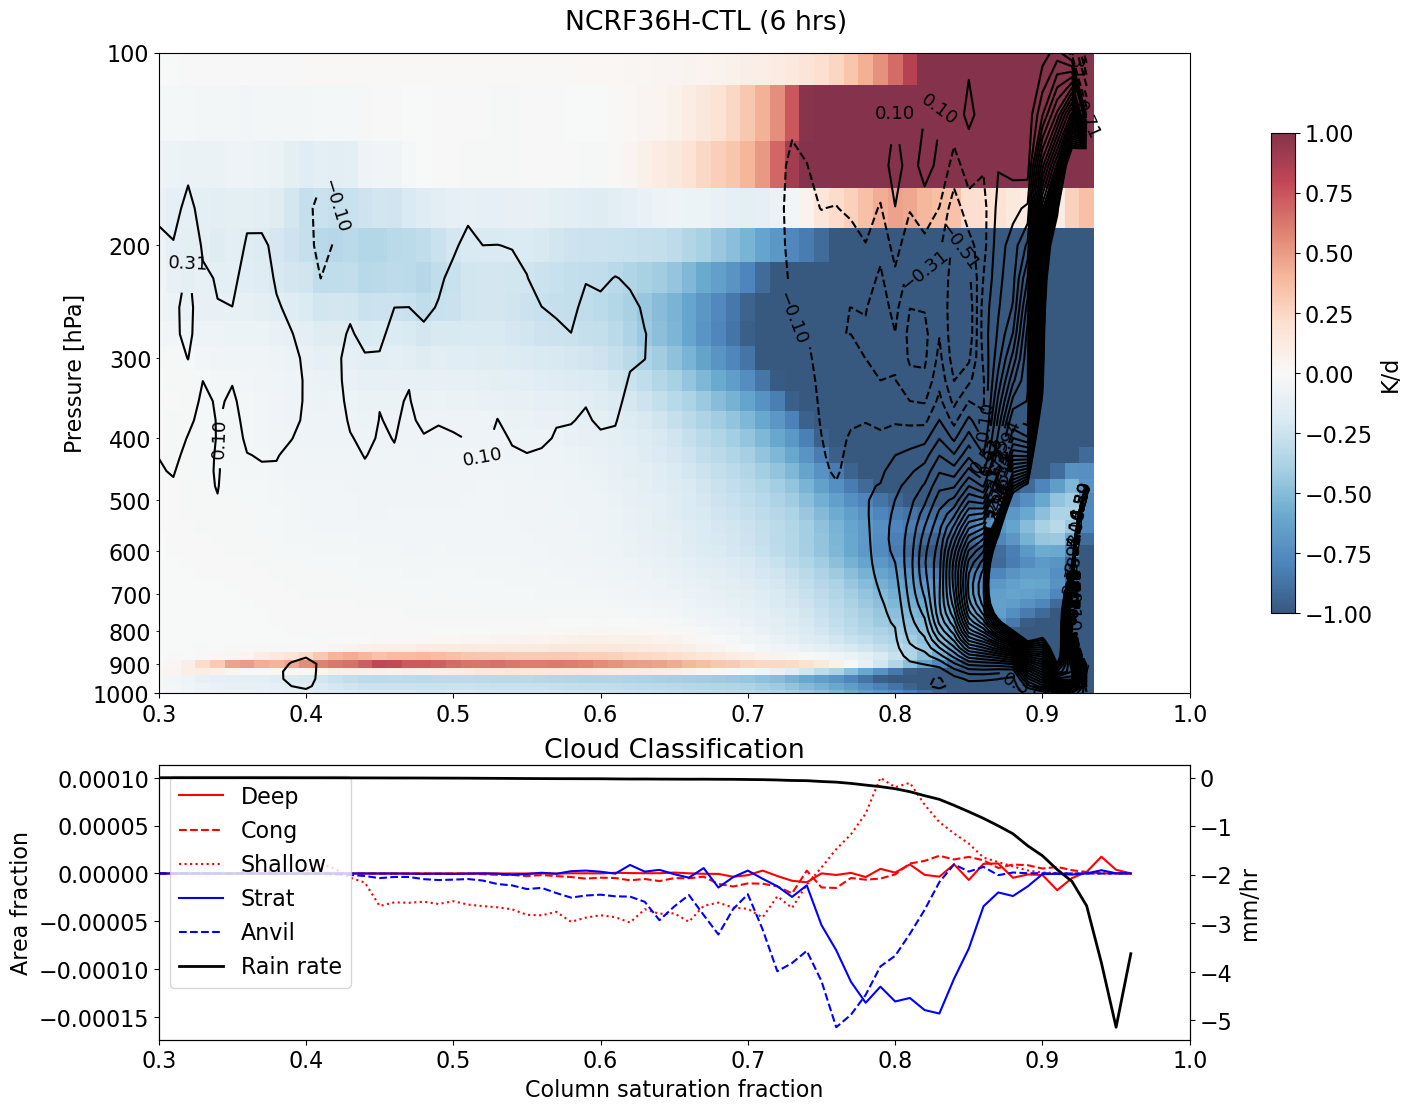

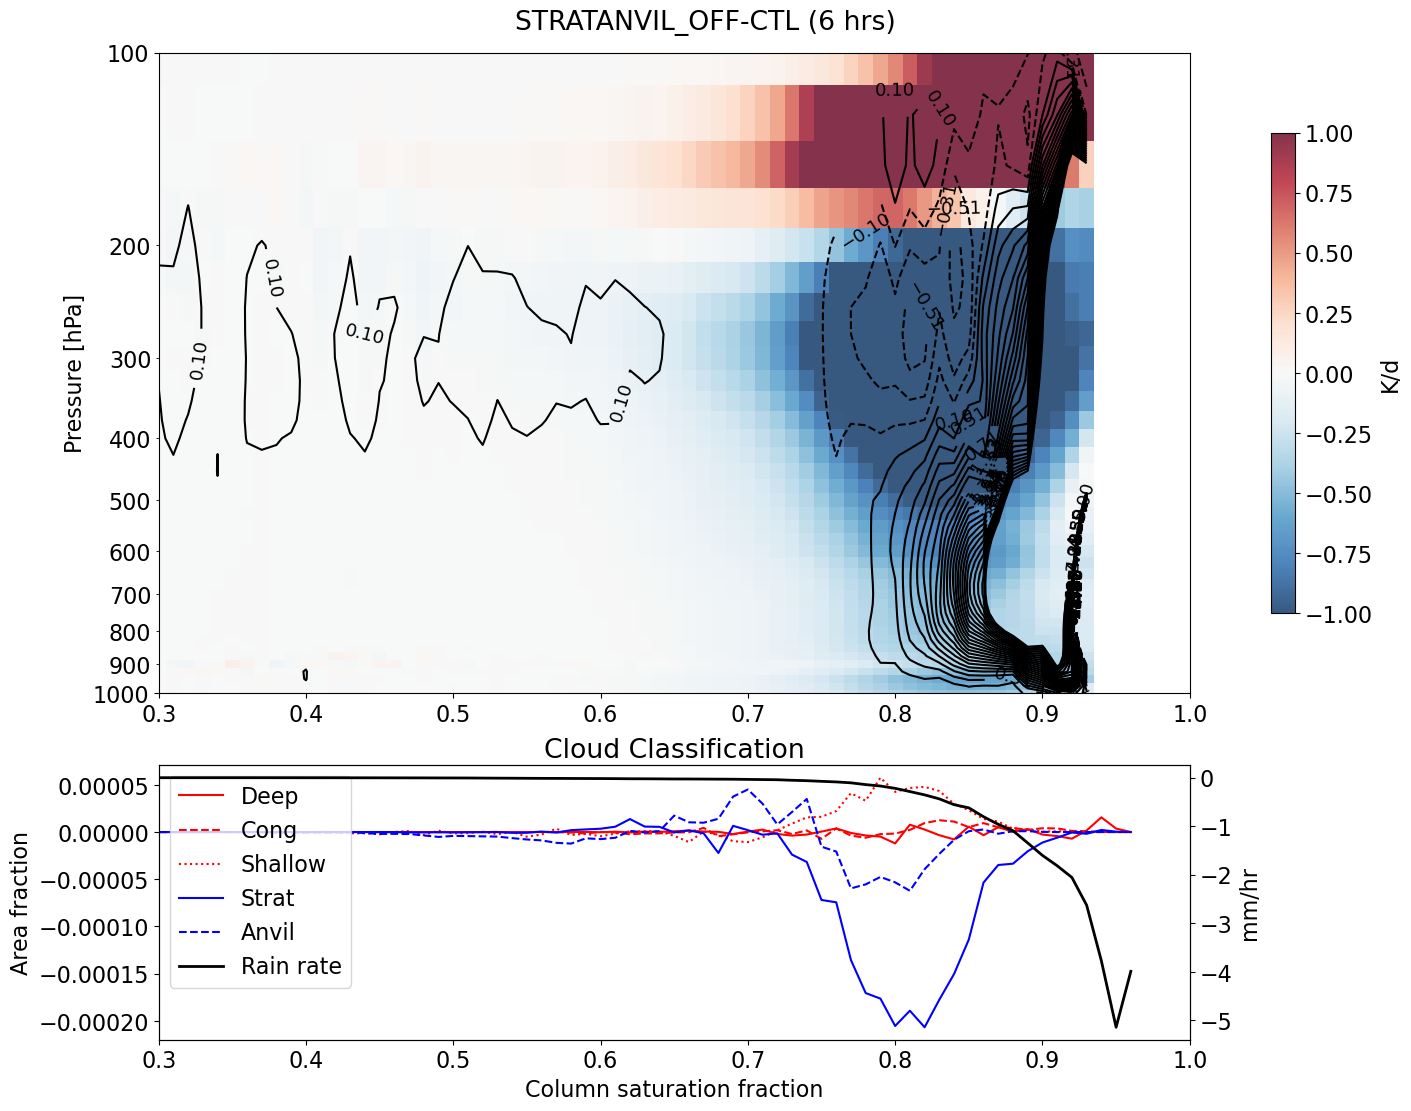

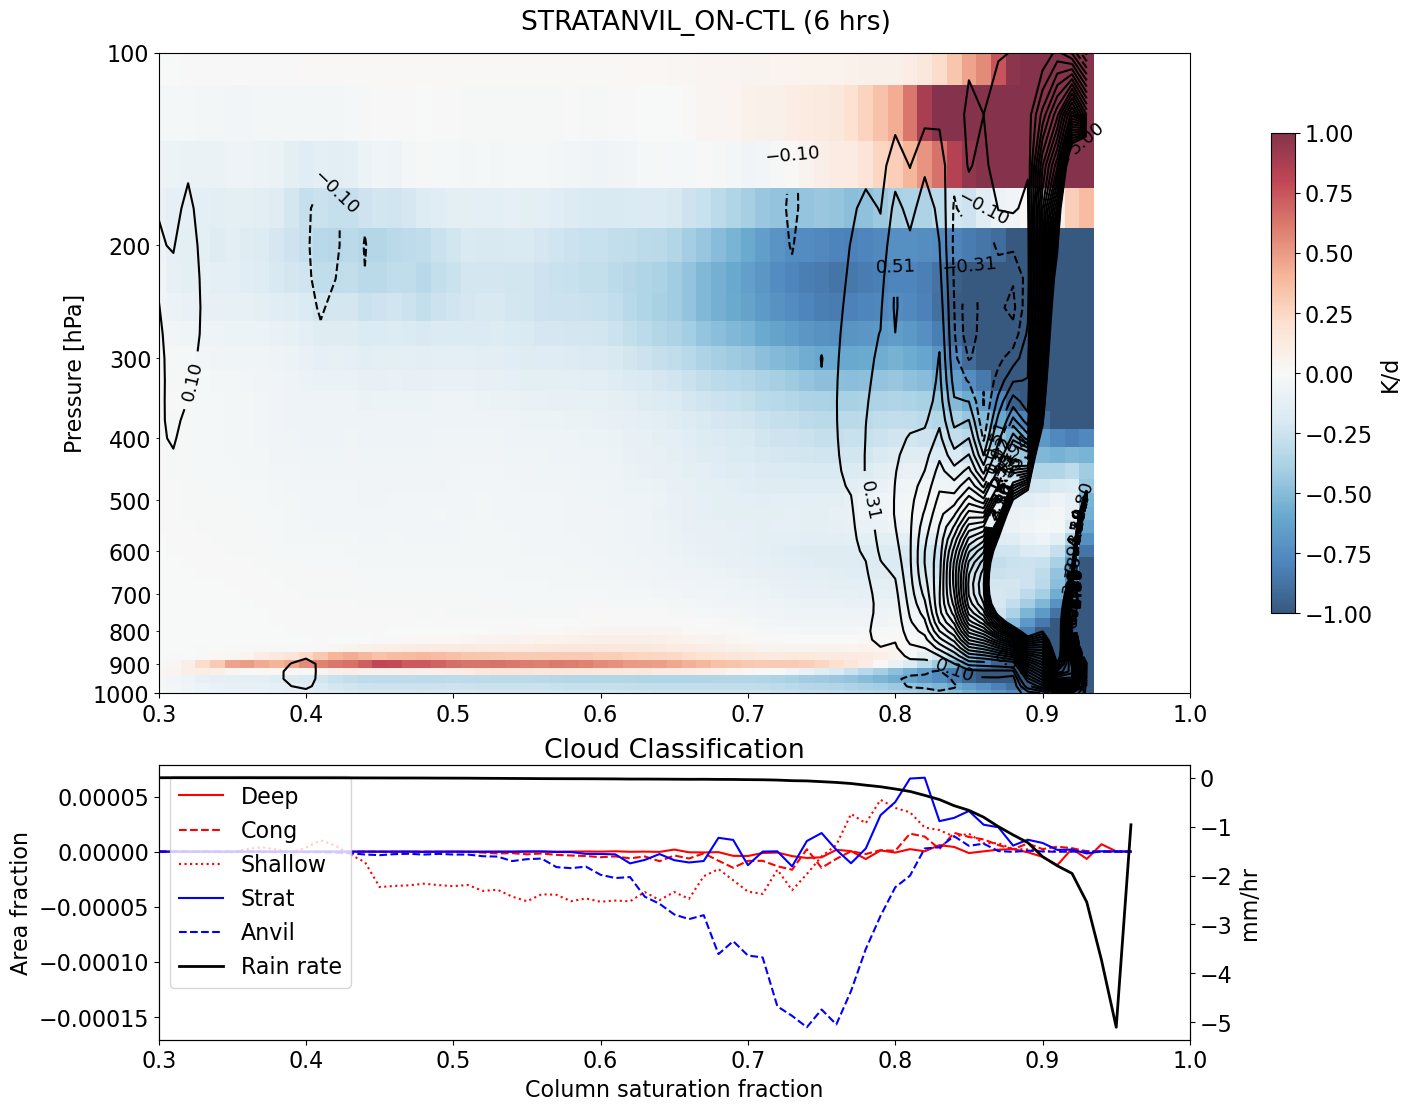

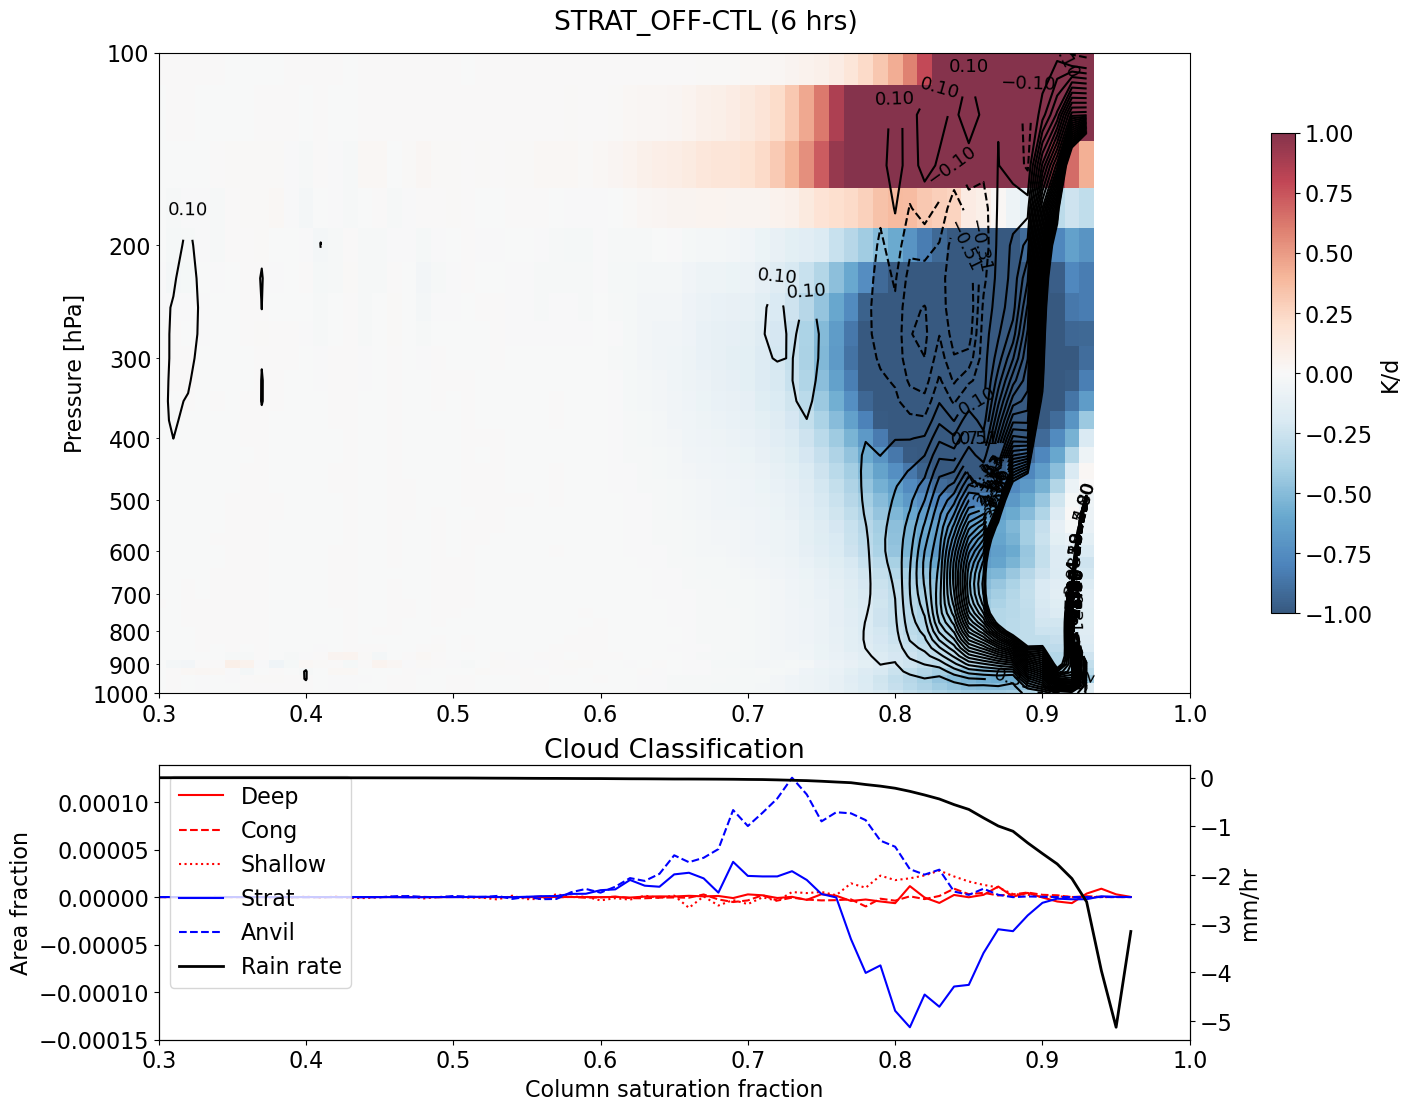

In [13]:
# Loop over sensitivity tests

pltvar = np.copy(var_binned)
cpltvar = np.copy(cvar_binned)

# Smooth with running mean
for i in range(3):
        pltvar[:,1:-1,:] = (pltvar[:,0:-2,:] + pltvar[:,1:-1,:] + pltvar[:,2:,:])/3
        cpltvar[:,1:-1,:] = (cpltvar[:,0:-2,:] + cpltvar[:,1:-1,:] + cpltvar[:,2:,:])/3

pltvar_ctl = var_binned[0]
cpltvar_ctl = cvar_binned[0]

pltvar  -= pltvar_ctl[np.newaxis,...]
cpltvar -= cpltvar_ctl[np.newaxis,...]

strat_plot = np.copy(strat_binned)
strat_ctl = strat_plot[0]
strat_plot = (strat_plot - strat_ctl[np.newaxis,...])# / strat_ctl[np.newaxis,...]

rain_plot = np.copy(rain_binned)
rain_ctl = rain_plot[0]
rain_plot -= rain_ctl[np.newaxis,...]

for ktest in range(1,ntest):
# for ktest in range(1,2):

        test_str=tests[ktest].upper()+'-'+tests[0].upper()
        # if istrat > -1:
        #     fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
        # else:
        # fig_title = title+' ('+test_str.upper()+')'# ('+hr_tag+' h)'
        fig_title = test_str.upper()+' ('+str(nt)+' hrs)'
        
        # create figure
        # fig = plt.figure(figsize=(14,8))
        # ax = fig.add_subplot(111)
        fig, axs = plt.subplots(2, 1, figsize=(14,11), height_ratios=[.7,.3], layout='constrained',
                                squeeze=True)
        fig.suptitle(fig_title)

        ########################################

        # MAIN PANEL

        axs[0].set_ylabel('Pressure [hPa]')

        # fill contour
        # nlevs=31
        # inc=(cmax-cmin)/nlevs
        # clevs = np.arange(cmin, cmax+inc, inc)
        # im = axs[0].contourf(bins[0:nbins-1], pres, np.transpose(pltvar[ktest]), clevs, cmap=cmap, alpha=0.8, \
        #                 extend='both', zorder=2)
        norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
        im = axs[0].pcolormesh(bins[0:nbins-1], pres, np.transpose(pltvar[ktest]), cmap=cmap, alpha=0.8, \
                        norm=norm,zorder=2)

        fig.colorbar(im, ax=axs[0], shrink=0.75, ticks=ticker.AutoLocator(), label=units_var1,
                        pad=0.01)

        axs[0].set_ylim(100,np.max(pres))
        axs[0].invert_yaxis()
        axs[0].set_yscale('log')
        axs[0].set_xscale(log_x)
        axs[0].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[0].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

        # axs[0].set_xlabel(xlabel)
        axs[0].set_xlim(np.min(bins), np.max(bins))

        # Line contour
        # clevs = np.arange(lcmin, lcmax, lcint)
        # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
        nlevs=50
        vmax=5
        clevs = np.linspace(-1*vmax,vmax,num=nlevs)
        # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
        im = axs[0].contour(bins[0:nbins-1], pres, np.transpose(cpltvar[ktest]), clevs, colors='black', zorder=2)
        axs[0].clabel(im, im.levels, inline=True, fontsize=13)

        ########################################

        # STRAT FRACTION PANEL
        subp_title = 'Cloud Classification'# ('+hr_tag+' h)'
        axs[1].set_title(subp_title)
        axs[1].set_xlabel(xlabel)
        axs[1].set_xscale(log_x)

        # As fraction of all-points-total
        axs[1].set_ylabel('Area fraction')

        total=np.nansum(strat_binned[ktest,:,:])
        # axs[1].plot(bins[0:nbins-1], strat_binned[ktest,:,0]/total \
        #         , ".k", label="Non-raining")
        axs[1].plot(bins[0:nbins-1], strat_plot[ktest,:,1]/total \
                , "-r", label="Deep")
        axs[1].plot(bins[0:nbins-1], strat_plot[ktest,:,2]/total \
                , "--r", label="Cong")
        axs[1].plot(bins[0:nbins-1], strat_plot[ktest,:,3]/total \
                , ":r", label="Shallow")
        axs[1].plot(bins[0:nbins-1], strat_plot[ktest,:,4]/total \
                , "-b", label="Strat")
        axs[1].plot(bins[0:nbins-1], strat_plot[ktest,:,5]/total \
                , "--b", label="Anvil")

        axs[1].set_xlim(np.min(bins), np.max(bins))
        # axs[1].set_ylim(0, 0.020)

        # Dummy rain plot just to include in legend
        axs[1].plot(bins[0:nbins-1], rain_plot[ktest,:]*np.nan, "-k", label="Rain rate", linewidth=2)

        axs[1].legend(loc="upper left")

        axs2 = axs[1].twinx()
        rain_hrly = rain_plot/24 # mm/d --> mm/hr
        axs2.plot(bins[0:nbins-1], rain_hrly[ktest,:], "-k", label="Rain", linewidth=2)
        axs2.set_ylabel('mm/hr')

        # figtag2 = figtag+'_'+ivar_select+fig_extra
        # plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [14]:
# # Difference between sensitivity tests

# if istrat == -1:
#     fig_title = title+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'
# else:
#     fig_title = title+': '+strattag+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'

# # create figure
# fig = plt.figure(figsize=(14,8))
# ax = fig.add_subplot(111)

# ax.set_title(fig_title)
# ax.set_ylabel('Pressure [hPa]')

# pltvar =  var_binned[0,:,:] - var_binned[1,:,:]
# cpltvar = cvar_binned[0,:,:]  - cvar_binned[1,:,:]

# # fill contour
# nlevs=21
# inc=(cmax_diff-cmin_diff)/nlevs
# clevs = np.arange(cmin_diff, cmax_diff+inc, inc)
# im = ax.contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.8, \
#                 extend='max', zorder=2)

# cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
# cbar.ax.set_ylabel(units_var1)

# plt.ylim(100,np.max(pres))
# ax.invert_yaxis()
# ax.set_yscale('log')
# ax.set_xscale(log_x)
# ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

# ax.set_xlabel(xlabel)
# plt.xlim(np.min(bins), np.max(bins))

# # ax2=ax.twinx()
# # im = ax.plot(bins[0:nbins-1], binvar_s_mn)

# # line contour
# # clevs = np.arange(lcmin, lcmax, lcint)
# # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
# clevs = [0.2,0.5,1,2]
# clevs = [.5,1,5,10,50]
# clevs = np.concatenate((-1*np.flip(clevs),clevs))
# # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
# im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
# ax.clabel(im, im.levels, inline=True, fontsize=13)

# figtag2 = figtag+'_'+ivar_select+fig_extra
# plt.savefig(figdir+'binnedcross_'+figtag2+'_diff_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)
# plt.show()
# plt.close()


In [15]:
# # Loop over sensitivity tests

# fig_title = 'Conv/Strat Separation ('+tests[0].upper()+'-'+tests[1].upper()+')'# ('+hr_tag+' h)'

# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title(fig_title)
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# # Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

# strat_var = strat_binned[0,:,:] - strat_binned[1,:,:]

# # As fraction of all-points-total
# ax.set_ylabel('Fraction')
# total=np.sum(strat_binned[0,:,:])

# plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)

# plt.plot(bins[0:nbins-1], strat_var[:,0]/total \
#         , ".k", label="Non-raining")
# plt.plot(bins[0:nbins-1], strat_var[:,1]/total \
#         , "-r", label="Deep")
# plt.plot(bins[0:nbins-1], strat_var[:,2]/total \
#         , "--r", label="Cong")
# plt.plot(bins[0:nbins-1], strat_var[:,3]/total \
#         , ":r", label="Shallow")
# plt.plot(bins[0:nbins-1], strat_var[:,4]/total \
#         , "-b", label="Strat")
# plt.plot(bins[0:nbins-1], strat_var[:,5]/total \
#         , "--b", label="Anvil")

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(-0.002, 0.002)

# plt.legend(loc="upper left")

# # plt.savefig(figdir+'binnedcross_convstrat_diff_ens'+enstag+'m_'+ivar_select+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)
# plt.show()
# plt.close()


 ### LW ACRE

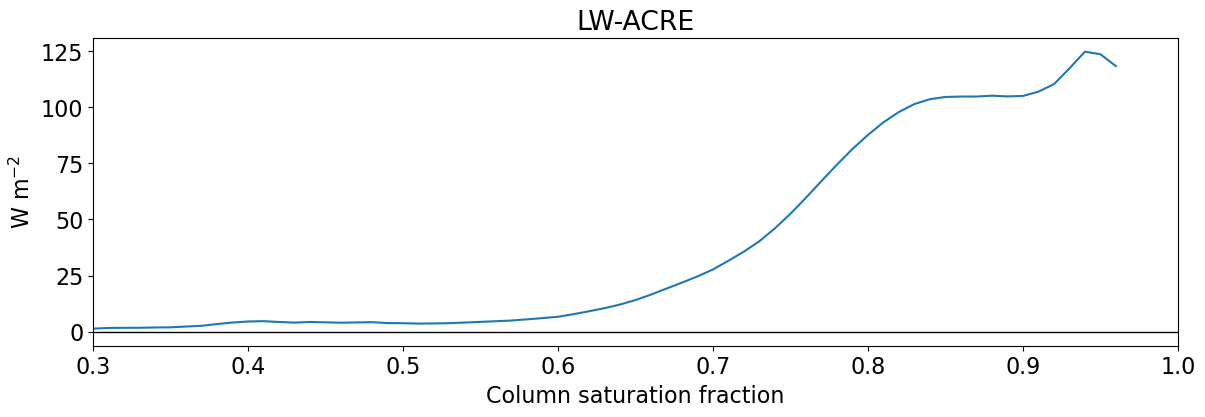

In [16]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

vartag_2d='LW-ACRE'
figtag='lwacre_binned'
ytag='W m$^{-2}$'

ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

for ktest in range(0,1):
        
        plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)
        
        # As fraction of all-rain-total
        # total=np.sum(strat_binned[:,(1,2,3)])
        # plt.plot(bins[0:nbins-1], var2d_binned_mn*strat_binned[:,0]/total \
        #          , ".k", label="Non-raining")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,1]/total \
        #          , "-r", label="Conv")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,2]/total \
        #          , "-b", label="Strat")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,3]/total \
        #          , "--b", label="Other")
        plt.plot(bins[0:nbins-1], lwacre_binned[ktest,:])

        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 10)

        # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
        # plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()


 ### LW ACRE by classification

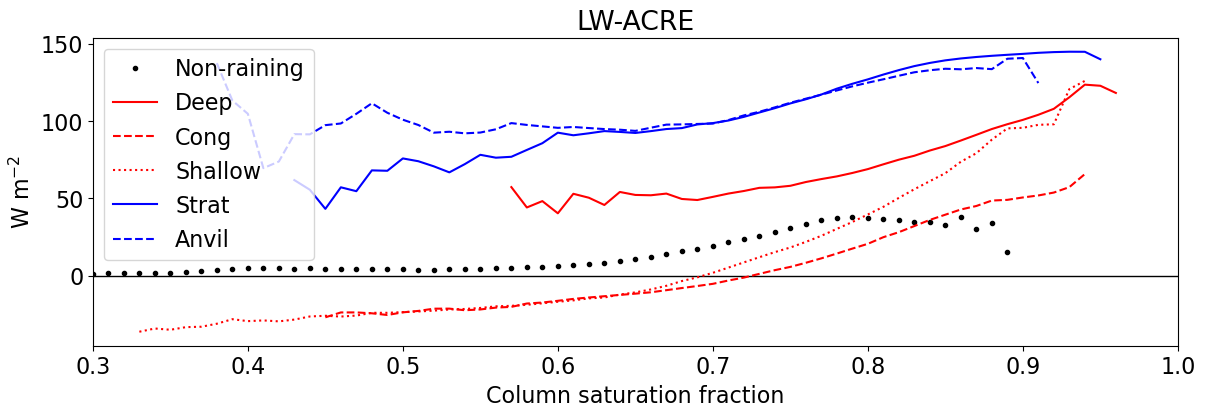

In [17]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

vartag_2d='LW-ACRE'
figtag='lwacrestrat'
ytag='W m$^{-2}$'

ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

for ktest in range(0,1):
        
        plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)
        
        # As fraction of all-rain-total
        # total=np.sum(strat_binned[:,(1,2,3)])
        # plt.plot(bins[0:nbins-1], var2d_binned_mn*strat_binned[:,0]/total \
        #          , ".k", label="Non-raining")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,1]/total \
        #          , "-r", label="Conv")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,2]/total \
        #          , "-b", label="Strat")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,3]/total \
        #          , "--b", label="Other")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,0] \
                , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,1] \
                , "-r", label="Deep")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,2] \
                , "--r", label="Cong")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,3] \
                , ":r", label="Shallow")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,4] \
                , "-b", label="Strat")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,5] \
                , "--b", label="Anvil")

        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 10)

        plt.legend(loc="upper left")

        # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
        # plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()


 ### Weighted LW ACRE by classification

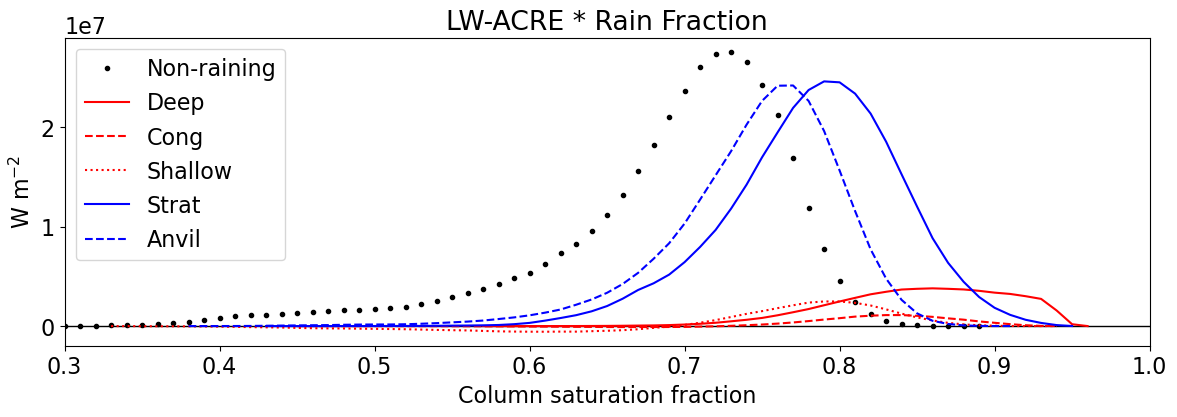

In [18]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

vartag_2d='LW-ACRE'
figtag='lwacrestrat'
ytag='W m$^{-2}$'

ax.set_title('LW-ACRE * Rain Fraction')
# ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

for ktest in range(0,1):
        
        plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)
        
        # As fraction of all-rain-total
        total=np.sum(strat_binned[ktest,:,:])
        fraction = strat_binned[ktest,:,:]#/total

        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,0]*fraction[:,0] \
                 , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,1]*fraction[:,1] \
                 , "-r", label="Deep")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,2]*fraction[:,2] \
                 , "--r", label="Cong")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,3]*fraction[:,3] \
                 , ":r", label="Shallow")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,4]*fraction[:,4] \
                 , "-b", label="Strat")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,5]*fraction[:,5] \
                 , "--b", label="Anvil")

        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 10)

        plt.legend(loc="upper left")

        # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
        plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()


 ### MSE'LW' by classification

In [19]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# mse_plot = mselw_strat / msevar[:,np.newaxis,np.newaxis]
# mse_plot *= 3600*24

# vartag_2d="$h'LW'$"
# figtag='hplwpstrat'
# ytag='Normalized [/day]'

# # ax.set_title('LW-ACRE * Rain Fraction')
# ax.set_title(vartag_2d)
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# ax.set_ylabel(ytag)

# for ktest in range(0,1):
        
#         plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)

#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,0] \
#                 , ".k", label="Non-raining")
#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,1] \
#                 , "-r", label="Conv")
#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,2] \
#                 , "-b", label="Strat")
#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,3] \
#                 , "--b", label="Other")

#         plt.xlim(np.min(bins), np.max(bins))
#         # plt.ylim(0, 10)

#         plt.legend(loc="upper left")

#         # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#         plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
#                         bbox_inches='tight', pad_inches=0.2)
#         plt.show()


 ### Weighted MSE'LW' by classification

In [20]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# mse_plot = mselw_strat / msevar[:,np.newaxis,np.newaxis]
# scale=2
# mse_plot *= 3600*24 * 10**scale

# vartag_2d="Area-weighted $h'LW'$"
# figtag='hplwpstrat_weighted'
# ytag='Normalized [$10^{-'+str(scale)+'}$ /day]'

# # ax.set_title('LW-ACRE * Rain Fraction')
# ax.set_title(vartag_2d)
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# ax.set_ylabel(ytag)

# for ktest in range(0,1):
        
#         # As fraction of all-rain-total
#         total=np.sum(strat_binned[ktest,:,:])
#         fraction = strat_binned[ktest,:,:]/total
#         sums = np.sum(fraction,axis=0)*1e2

#         isums = str(np.around(sums[0], decimals=2))
#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,0]*fraction[:,0] , ".k", label="Non-raining ("+isums+")")
#         isums = str(np.around(sums[1], decimals=2))
#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,1]*fraction[:,1] , "-r", label="Conv ("+isums+")")
#         isums = str(np.around(sums[2], decimals=2))
#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,2]*fraction[:,2] , "-b", label="Strat ("+isums+")")
#         isums = str(np.around(sums[3], decimals=2))
#         plt.plot(bins[0:nbins-1], mse_plot[ktest,:,3]*fraction[:,3] , "--b", label="Anvil ("+isums+")")

#         plt.xlim(np.min(bins), np.max(bins))
#         # plt.ylim(0, 10)

#         plt.legend(loc="upper left")

#         # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#         plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
#                         bbox_inches='tight', pad_inches=0.2)
#         plt.show()


 ### VMF

In [21]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title('Vertical mass flux')
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# # ax.set_ylabel('kg/m/s')
# # plt.plot(bins[0:nbins-1], binvar_vmfl_mn, "-k", label="Lower")
# # plt.plot(bins[0:nbins-1], binvar_vmfh_mn, "--k", label="Upper")
# ax.set_ylabel('%')
# plt.plot(bins[0:nbins-1], binvar_vmfth_mn, "-k", label="TH index")

# plt.xlim(np.min(bins), np.max(bins))
# # plt.ylim(0, 0.2)
# # ax.set_yscale('log')

# plt.legend(loc="upper left")


# plt.show()
# # plt.savefig(figdir+'convstrat_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)


 ### Test of vertical mode decomposition

In [22]:
# # A specific, known sinusoidal function
# nlevs=100
# nharmonic = 5
# scale = [3.,9,15,25,50,100]
# # scale = np.ones(nharmonic)
# zind=np.arange(0,1,1./nlevs)
# fx = np.zeros(nlevs)
# for nk in range(nharmonic):
#     fx += np.sin(2*np.pi*(nk+1)*zind) * scale[nk]
#     # print(np.sin(2*np.pi*(nk+1)*zind))


# an = np.zeros(nharmonic)
# bn = np.zeros(nharmonic)
# for nk in range(nharmonic):
#     # print("k = ",nk+1)
#     kx = 2*np.pi * (nk+1) * zind
#     # print("kx = ",kx)
#     an[nk] = (2./nlevs) * np.sum( fx * np.cos(kx) )
#     bn[nk] = (2./nlevs) * np.sum( fx * np.sin(kx) )

# # # power=np.sqrt(an**2 + bn**2)
# power=an + bn
# # power=np.abs(power)
# # print(an)
# print(power)

# # create figure
# fig = plt.figure(figsize=(5,4))
# ax = fig.add_subplot(111)
# ax.set_title('Sine function')
# ax.set_ylabel('z/H')

# plt.plot(fx, zind)

# plt.show()


 ### LW ACRE

In [23]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title('LW-ACRE')
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# pltvar=binvar_acre_mn

# ax.set_ylabel('ACRE [W/m**2]')
# plt.plot(bins[0:nbins-1], pltvar)

# # plt.ylim(0, 0.2)
# plt.xlim(np.min(bins), np.max(bins))

# # plt.legend(loc="upper left")

# plt.show()
# # plt.savefig(figdir+'lwacre_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)


